## Obtain Intraseasonal Weahter Types (IWT, at daily scale) following the methodology explained in Anderson et al. (2019)

inputs required: 
  * Daily values of Madden-Julian Oscillation (MJO) parameters (rmm1, rmm2, phase, mjo)

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
from datetime import date, timedelta, datetime

# pip
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.mjo import GetMJOCategories
from teslakit.plotting.mjo import Plot_MJOphases, Plot_MJOCategories
from teslakit.alr import ALR_WRP



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
# --------------------------------------
# load data and set parameters

xds_mjo_hist = db.Load_MJO_hist()  # historical MJO

# MJO ALR parameters
alr_markov_order = 3
alr_seasonality = [2, 4, 8]
alr_num_categs = 25

# Simulation
num_sims = 1
d1_sim = np.datetime64('2020-01-01').astype(datetime)
d2_sim = np.datetime64('3020-01-01').astype(datetime)



## MJO phases and categories

In [4]:
# --------------------------------------
# Calculate MJO categories (25 used) 

rmm1 = xds_mjo_hist['rmm1']
rmm2 = xds_mjo_hist['rmm2']
phase = xds_mjo_hist['phase']

categ, d_rmm_categ = GetMJOCategories(rmm1, rmm2, phase)
xds_mjo_hist['categ'] = (('time',), categ)

print(xds_mjo_hist)


<xarray.Dataset>
Dimensions:  (time: 14343)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-04-08
Data variables:
    phase    (time) int64 6 7 7 7 7 7 7 6 6 6 7 7 7 ... 7 7 7 7 7 7 7 8 8 8 1 1
    rmm1     (time) float64 0.1425 -0.2042 -0.1586 ... -2.314 -2.547 -2.655
    rmm2     (time) float64 1.05 1.374 1.539 1.46 ... 0.3049 -0.05768 -0.2531
    mjo      (time) float64 ...
    categ    (time) int64 22 23 15 23 23 23 23 22 14 ... 15 15 15 15 8 16 16 1 1


<xarray.DataArray 'rmm1' (time: 2)>
array([-0.2042 , -0.15861])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02 1979-01-03
<xarray.DataArray 'rmm2' (time: 2)>
array([1.37361, 1.53943])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02 1979-01-03


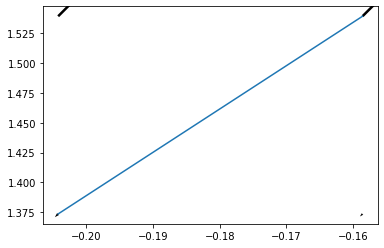

In [8]:
ini = 1
fin = 3
x = rmm1.isel(time=slice(ini,fin))
y = rmm2.isel(time=slice(ini,fin))
print(x)
print(y)

plt.plot(x, y)
plt.quiver(x, y, [x, y],[x, y])

plt.arrow(0, f(0), 0.01, f(0.01)-f(0), shape='full', lw=0, length_includes_head=True, head_width=.05)


#plt.xlim([-2, 2])
#plt.ylim([-2, 2])
plt.show()

In [ ]:
ini = 1
fin = 20
plt.plot(rmm1.isel(time=slice(ini,fin)), rmm2.isel(time=slice(ini,fin)))
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()

In [ ]:
# plot MJO phases
Plot_MJOphases(rmm1, rmm2, phase)


In [ ]:
# plot MJO categories
Plot_MJOCategories(rmm1, rmm2, categ)



## Autoregressive Logistic Regression

In [ ]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

# MJO historical data for fitting
xds_bmus_fit = xr.Dataset(
    {
        'bmus'  :(('time',), xds_mjo_hist.categ.values[:]),
    },
    {'time' : xds_mjo_hist.time}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'seasonality': (True, alr_seasonality),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.MJO.alrw)
ALRW.SetFitData(alr_num_categs, xds_bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=10000)


In [ ]:
# show fit report
ALRW.Report_Fit(summary=True)


In [ ]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates
dates_sim = [d1_sim + timedelta(days=i) for i in range((d2_sim-d1_sim).days+1)]

# launch simulation
xds_alr = ALRW.Simulate(num_sims, dates_sim)
evbmus_sim = np.squeeze(xds_alr.evbmus_sims.values[:])

# Generate mjo rmm1 and rmm2 simulated values
rmm12_sim = np.empty((len(evbmus_sim), 2)) * np.nan
for c, m in enumerate(evbmus_sim):
    options = d_rmm_categ['cat_{0}'.format(int(m))]
    r = np.random.randint(options.shape[0])
    rmm12_sim[c,:] = options[r,:]

# calculate mjo and phase
mjo_sim = np.sqrt(rmm12_sim[:,0]**2+rmm12_sim[:,1]**2)
phase_sim = np.arctan2(rmm12_sim[:,0], rmm12_sim[:,1])

# store simulated mjo
xds_MJO_sim = xr.Dataset(
    {
        'mjo'   :(('time',), mjo_sim),
        'phase' :(('time',), phase_sim),
        'rmm1'  :(('time',), rmm12_sim[:,0]),
        'rmm2'  :(('time',), rmm12_sim[:,1]),
    },
    {'time' : dates_sim}
)
print(xds_MJO_sim)

db.Save_MJO_sim(xds_MJO_sim)


In [ ]:
# show simulation report
ALRW.Report_Sim()
